# AirBnB in NYC: Accommodation Segmentation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from yellowbrick.cluster import KElbowVisualizer
import os
import math

# NLP
import nltk 
from nltk.corpus import stopwords
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

In [2]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [3]:
path = '/Users/admin/Documents/BC#2/Labs/Week08/AirBnB-customer-segmentation/'

In [4]:
df = pd.read_csv(path + "AB_NYC_2019.csv")

In [5]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [7]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

#### DataFrame description
The columns `last_review` and `reviews_per_month` are the ones presenting the highest number of missing values (10052). We can check whether those missing `last_review` are also missing `reviews_per_month`: if the place did not receive any review, the larst review and the reviews_per_month are centainly missing. 
Secondly, `host_name` and `name` present a few missing values (21 and 16 respectively) and also those are removed. 

### Missing values

In [8]:
# Drop NaNs in `host_name` , `name` , last_review and reviews_per_month
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)

In [9]:
# Convert revelant categorical columns into integers
df['neighbourhood_group_int'] = df['neighbourhood_group'].map({'Brooklyn':1, 'Manhattan':2, 'Queens':3, 'Staten Island':4, 'Bronx':5})
df['room_type_int'] = df['room_type'].map({'Private room':1, 'Entire home/apt':2, 'Shared room':3})
    

### Outliers 

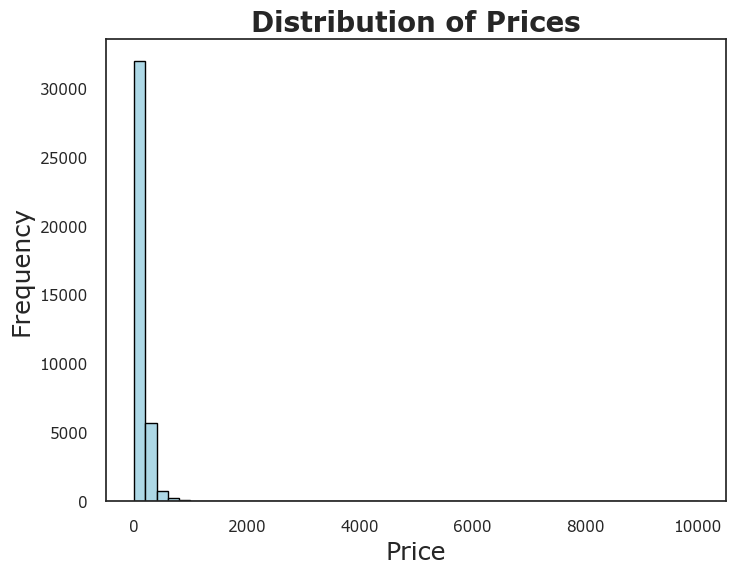

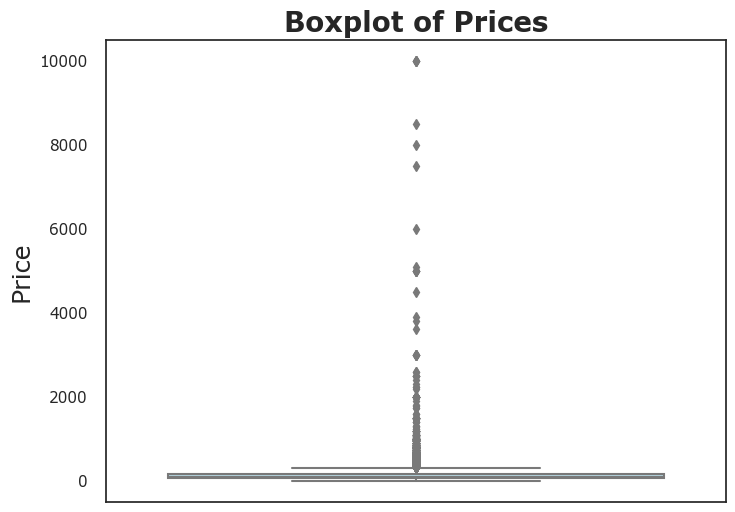

In [10]:
# Price
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(data=df, x='price', bins=50, color='lightblue', edgecolor='black')
plt.xlabel('Price', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Distribution of Prices', fontsize=20, fontweight='bold')
plt.grid(False)
plt.show()

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='price', color='lightblue')
plt.ylabel('Price', fontsize=18)
plt.title('Boxplot of Prices', fontsize=20, fontweight='bold')
plt.grid(False)
plt.show()

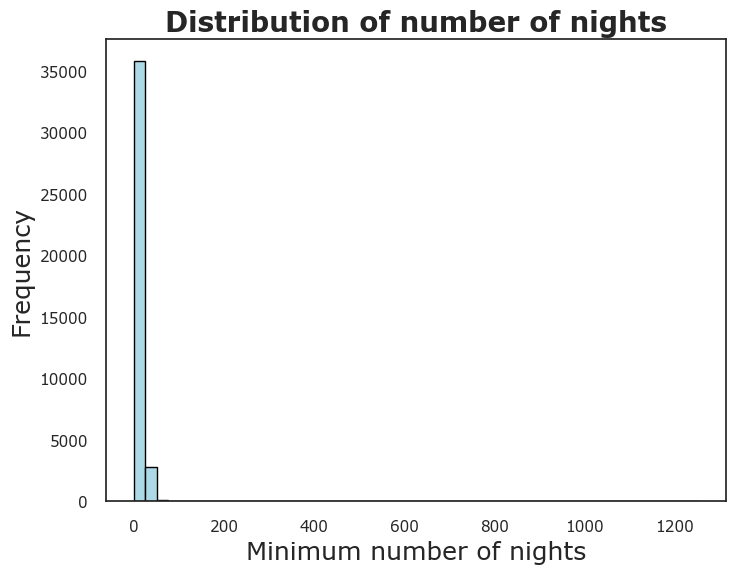

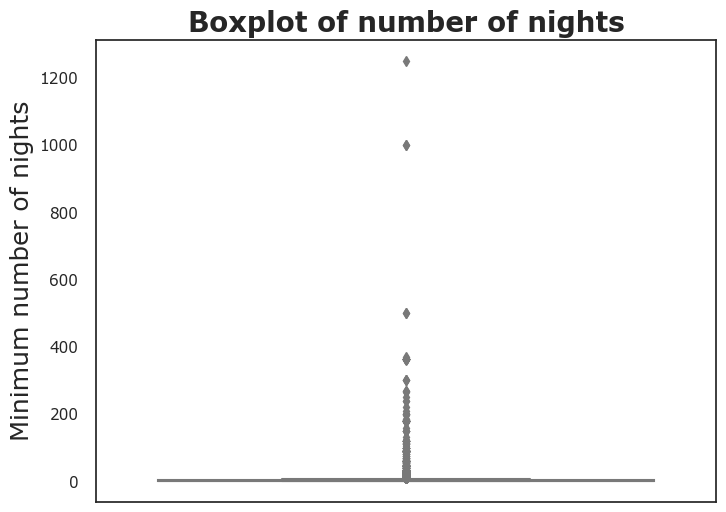

In [11]:
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})

# minimum_nights
plt.figure(figsize=(8, 6))
plt.hist(data=df, x='minimum_nights', bins=50, color='lightblue', edgecolor='black')
plt.xlabel('Minimum number of nights', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Distribution of number of nights', fontsize=20, fontweight='bold')
plt.grid(False)
plt.show()

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='minimum_nights', color='lightblue')
plt.ylabel('Minimum number of nights', fontsize=18)
plt.title('Boxplot of number of nights', fontsize=20, fontweight='bold')
plt.grid(False)
plt.show()

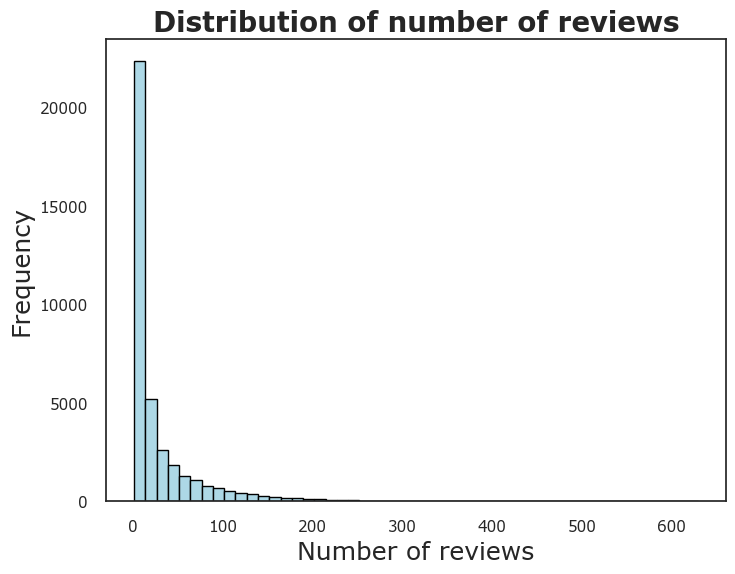

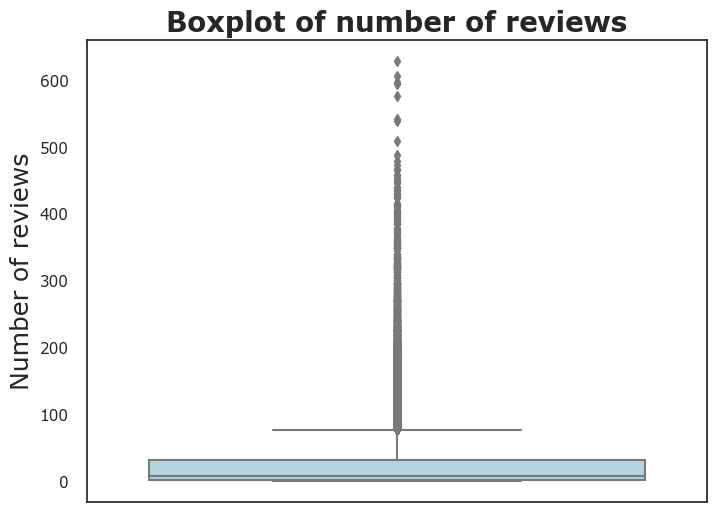

In [12]:
# number_of_reviews
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(data=df, x='number_of_reviews', bins=50, color='lightblue', edgecolor='black')
plt.xlabel('Number of reviews', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Distribution of number of reviews', fontsize=20, fontweight='bold')
plt.show()

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='number_of_reviews', color='lightblue')
plt.ylabel('Number of reviews', fontsize=18)
plt.title('Boxplot of number of reviews', fontsize=20, fontweight='bold')
plt.show()

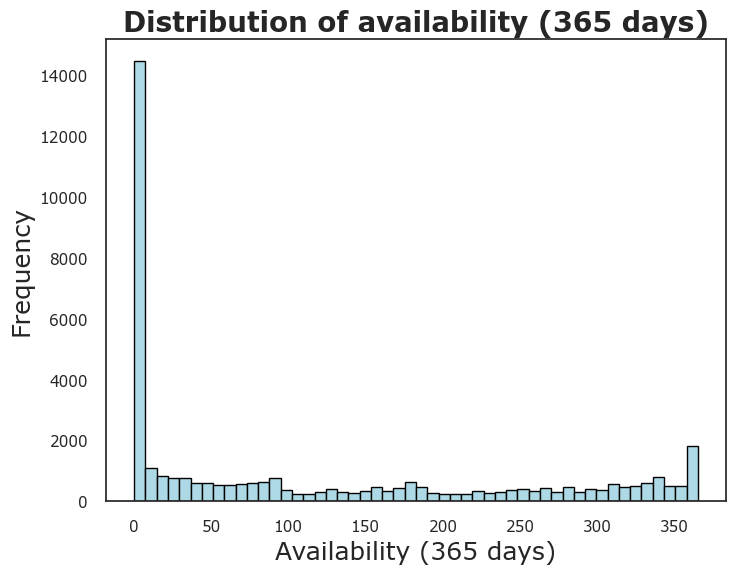

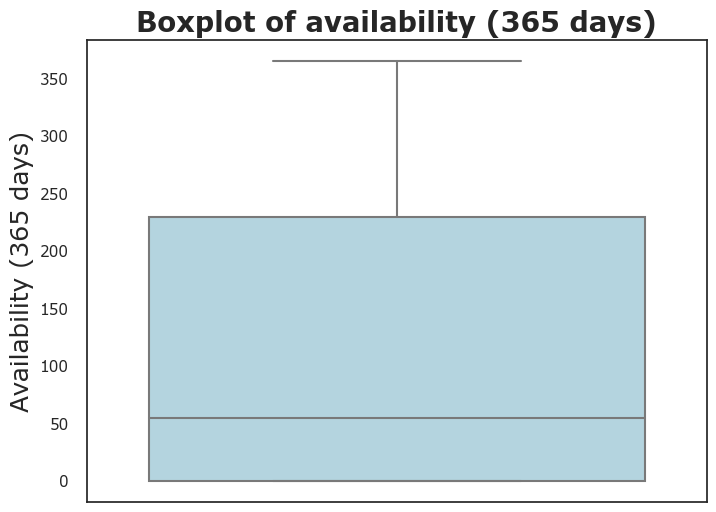

In [13]:
# Availability_365: it's Okay!!
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(data=df, x='availability_365', bins=50, color='lightblue', edgecolor='black')
plt.xlabel('Availability (365 days)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Distribution of availability (365 days)', fontsize=20, fontweight='bold')
plt.show()

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='availability_365', color='lightblue')
plt.ylabel('Availability (365 days)', fontsize=18)
plt.title('Boxplot of availability (365 days)', fontsize=20, fontweight='bold')
plt.show()

In [14]:
# Remove ouliers: outliers have a significant impact on clustering. 
# Hence it is better to identify and remove outliers before applying K-means clustering algorithm.

# price
df = remove_outlier(df, 'price')              # from 38821 --> 36744 = 2077 removed
# availability_365
df = remove_outlier(df, 'availability_365')   # from 36744 --> 36744 = 0 removed
# minimum_nights
df = remove_outlier(df, 'minimum_nights')     # from 36744 --> 32474 = 4270 removed
# number_of_reviews
df = remove_outlier(df, 'number_of_reviews')  # from 32474 --> 29164 = 3310 removed
# calculated_host_listings_count
df = remove_outlier(df, 'calculated_host_listings_count')  # from 29164 --> 26286 = 2878 removed
    
# drop if price == 0, because it is impossible
df.drop(df[df.price < 10].index, inplace=True)

    

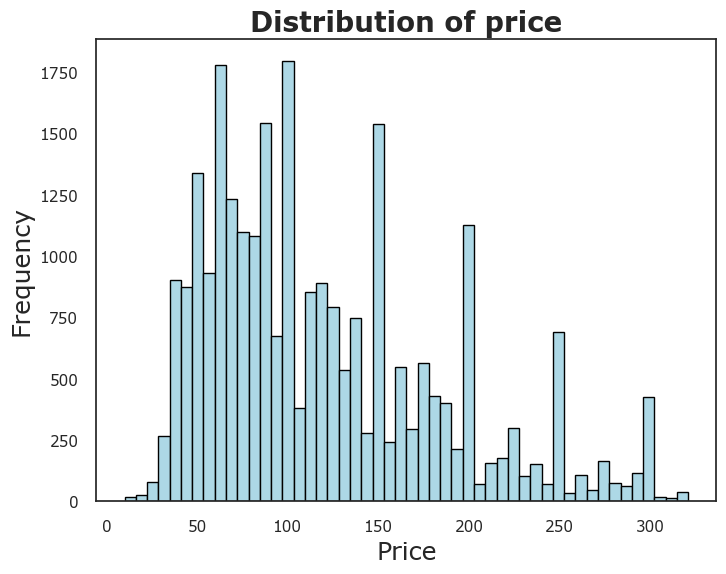

In [15]:
#### Normalize skewed data 
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(data=df, x='price', bins=50, color='lightblue', edgecolor='black')
plt.xlabel('Price', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Distribution of price', fontsize=20, fontweight='bold')
plt.show()

In [16]:
# Mean normalization of price: New value = (value – mean) / (standard deviation)
df['price_transf'] = np.log(df['price'])
df['minimum_nights_transf'] = np.log(df['minimum_nights'])
df['number_of_reviews_transf'] = np.log(df['number_of_reviews'])

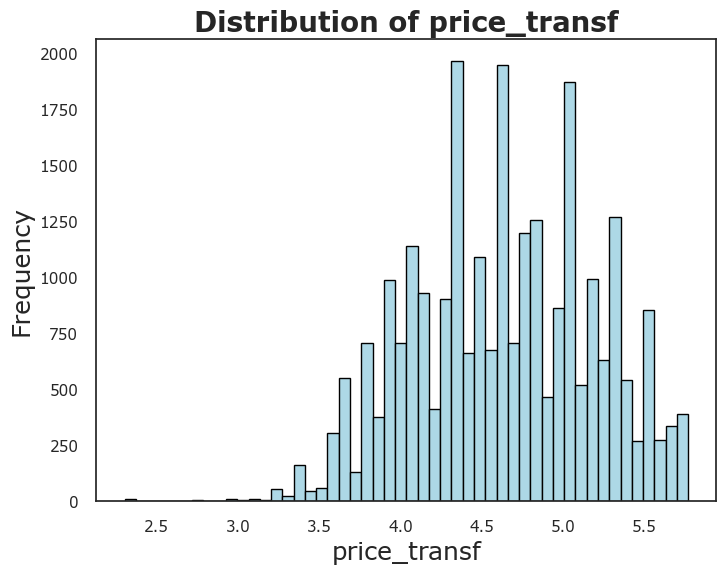

In [17]:
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(data=df, x='price_transf', bins=50, color='lightblue', edgecolor='black')
plt.xlabel('price_transf', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Distribution of price_transf', fontsize=20, fontweight='bold')
plt.show()

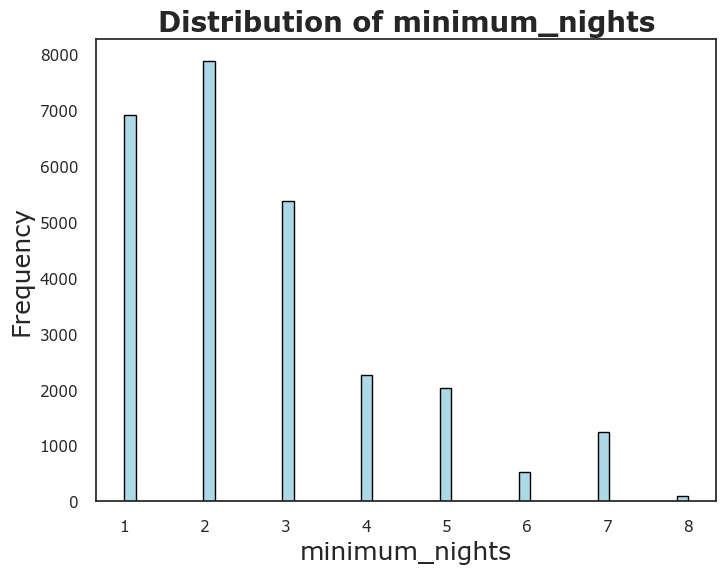

In [18]:
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(data=df, x='minimum_nights', bins=50, color='lightblue', edgecolor='black')
plt.xlabel('minimum_nights', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Distribution of minimum_nights', fontsize=20, fontweight='bold')
plt.show()

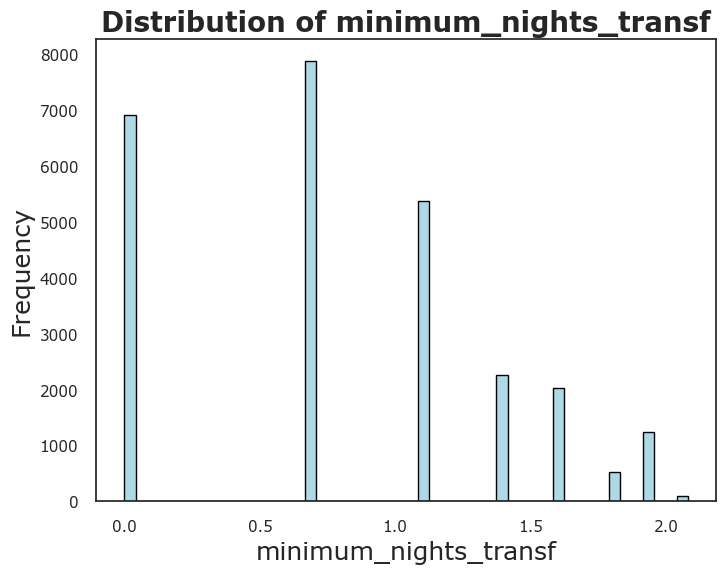

In [19]:
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(data=df, x='minimum_nights_transf', bins=50, color='lightblue', edgecolor='black')
plt.xlabel('minimum_nights_transf', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Distribution of minimum_nights_transf', fontsize=20, fontweight='bold')
plt.show()

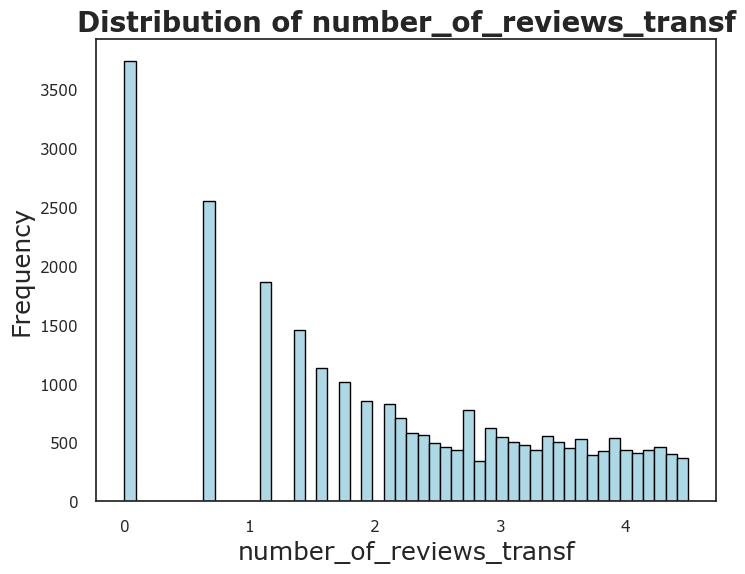

In [20]:
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(data=df, x='number_of_reviews_transf', bins=50, color='lightblue', edgecolor='black')
plt.xlabel('number_of_reviews_transf', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Distribution of number_of_reviews_transf', fontsize=20, fontweight='bold')
plt.show()

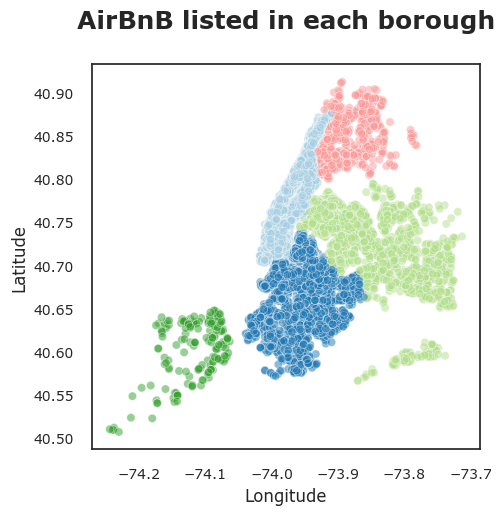

In [21]:
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})
colors = sns.color_palette("Paired", 5)

plt.figure(figsize=(5,5))
sns.scatterplot(data = df,
            y = 'latitude',
            x = 'longitude',
            hue = 'neighbourhood_group',
            #order=["Brooklyn", "Manhattan", "Queens", "Bronx", "Staten Island"],
            #style = 'clusters',
            palette=colors,
            alpha=0.5,
            legend = None)

#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Borough', ncol=1, title_fontsize='x-large')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('AirBnB listed in each borough\n', fontsize=18, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [22]:
#Get a count by borough
neighbourhood_group_count = df.groupby('neighbourhood_group').agg('count').reset_index()
neighbourhood_group_count

,neighbourhood_group,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_int,room_type_int,price_transf,minimum_nights_transf,number_of_reviews_transf
0,Bronx,623,623,623,623,623,623,623,623,623,...,623,623,623,623,623,623,623,623,623,623
1,Brooklyn,11657,11657,11657,11657,11657,11657,11657,11657,11657,...,11657,11657,11657,11657,11657,11657,11657,11657,11657,11657
2,Manhattan,10744,10744,10744,10744,10744,10744,10744,10744,10744,...,10744,10744,10744,10744,10744,10744,10744,10744,10744,10744
3,Queens,3044,3044,3044,3044,3044,3044,3044,3044,3044,...,3044,3044,3044,3044,3044,3044,3044,3044,3044,3044
4,Staten Island,216,216,216,216,216,216,216,216,216,...,216,216,216,216,216,216,216,216,216,216


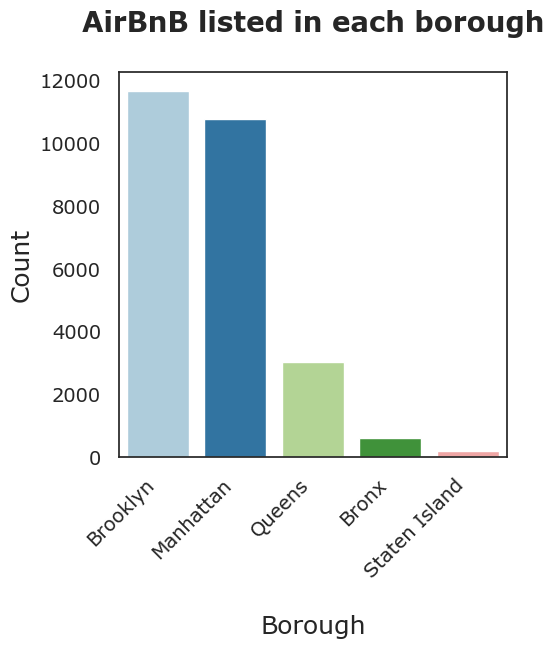

In [23]:
# Plot number of  AirBnB in each neighbourhood_group
plt.figure(figsize=(5,5))

sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})
colors = sns.color_palette("Paired", 5)
sns.countplot(palette=colors,
              data=df, x='neighbourhood_group', order=df['neighbourhood_group'].value_counts().index)
plt.xlabel('\nBorough', fontsize=18);
plt.ylabel('Count', fontsize=18);
plt.title('AirBnB listed in each borough\n', fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

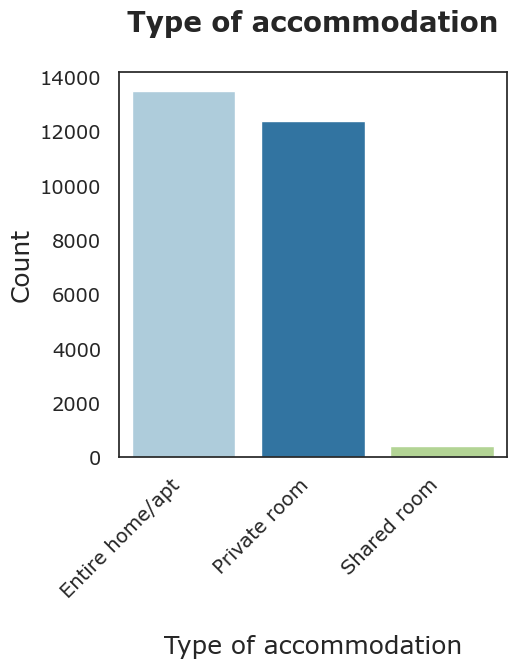

In [24]:
plt.figure(figsize=(5,5))
# Plot number of AirBnB by room_type
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})
colors = sns.color_palette("Paired", 3)

sns.countplot(palette=colors,data=df, x='room_type', order=df['room_type'].value_counts().index)
plt.xlabel('\nType of accommodation', fontsize=18);
plt.ylabel('Count', fontsize=18);
plt.title('Type of accommodation\n', fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

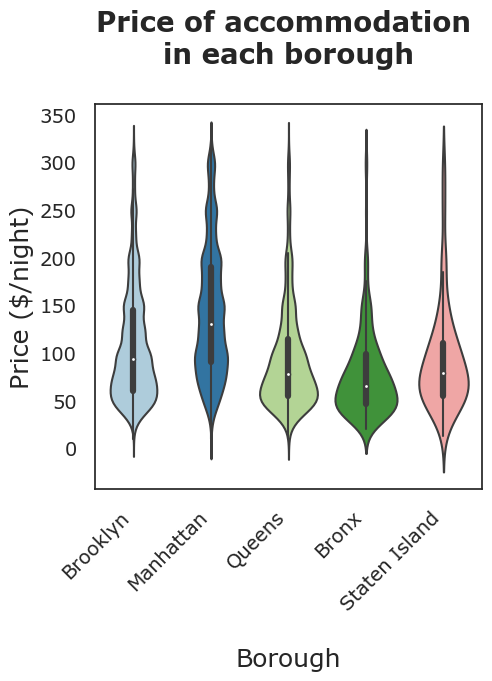

In [25]:
plt.figure(figsize=(5,5))

# Plot price by neighbourhood_group
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})
colors = sns.color_palette("Paired", 5)

sns.violinplot(palette=colors, data=df, x='neighbourhood_group', y='price',
              order=["Brooklyn", "Manhattan", "Queens", "Bronx", "Staten Island"])
plt.xlabel('\nBorough', fontsize=18);
plt.ylabel('Price ($/night)', fontsize=18);
plt.title('Price of accommodation \nin each borough\n', fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

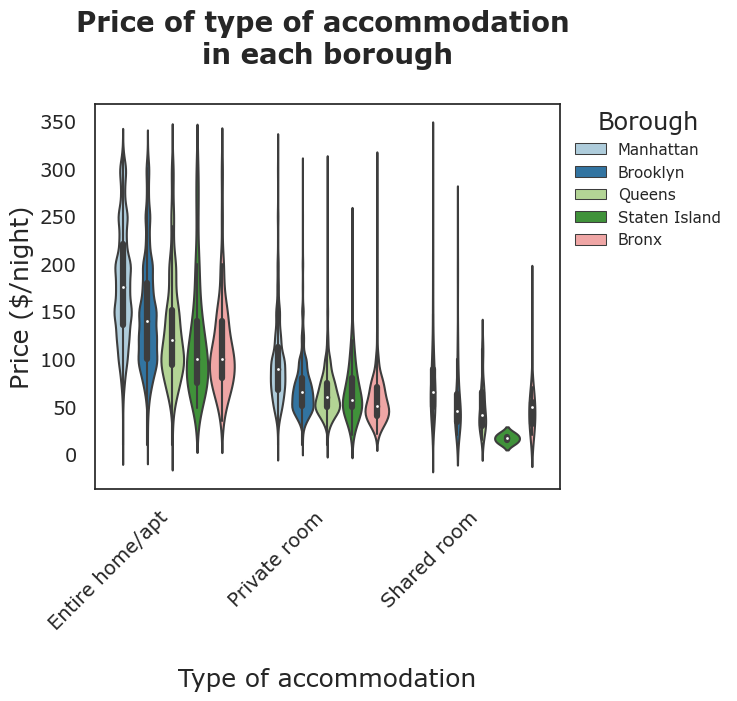

In [26]:
plt.figure(figsize=(6,5))

sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})
colors = sns.color_palette("Paired", 5)

# Plot price by neighbourhood_group
sns.violinplot(palette=colors, data=df, x='room_type', y='price', hue = 'neighbourhood_group')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Borough', ncol=1, title_fontsize='x-large')
plt.xlabel('\nType of accommodation', fontsize=18);
plt.ylabel('Price ($/night)', fontsize=18);
plt.title('Price of type of accommodation \nin each borough\n', fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()



#### Keep only numerical data

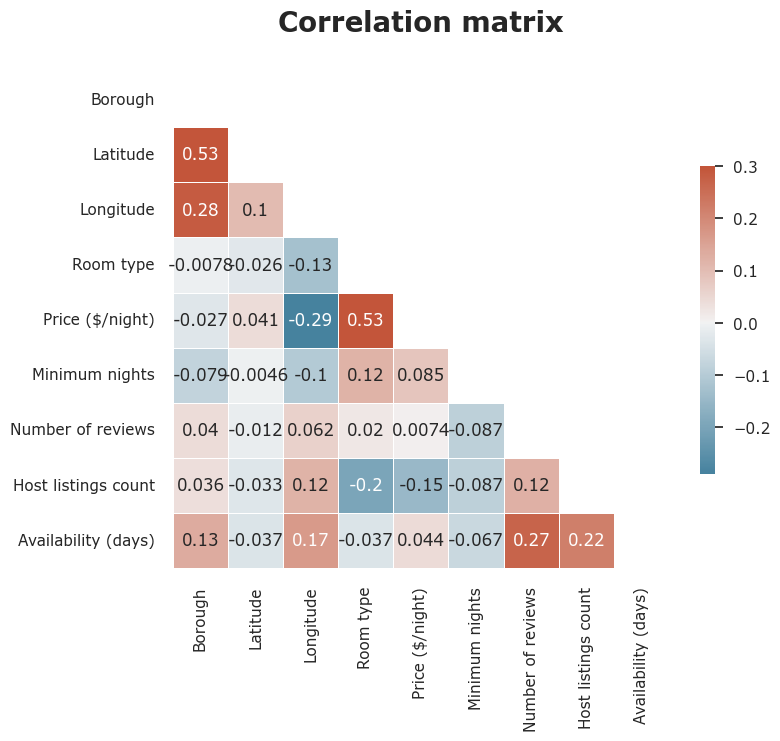

In [27]:
d = df[['neighbourhood_group_int','latitude', 'longitude', 'room_type_int', 'price',
       'minimum_nights', 'number_of_reviews', 
       'calculated_host_listings_count',
       'availability_365']]

d.columns = ['Borough', 'Latitude', 'Longitude', 'Room type',
       'Price ($/night)', 'Minimum nights', 'Number of reviews',
       'Host listings count', 'Availability (days)']

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.title('Correlation matrix\n', fontsize=20, fontweight='bold')
plt.show()

In [28]:
# Select columns with numerical values
df_num = df.select_dtypes("number").copy()

In [29]:
# drop unnecessary columns
df_num.drop(columns=['host_id', 'id', 'latitude', 'longitude', 'reviews_per_month'], inplace = True)

### Selecting number of clusters for k-means classification

#### The elbow method

In [30]:
# Getting the inertia values for a variety of different cluster numbers
inertia_dict = {
    'clusters': [],
    'inertia': []
}

for i in range(2,11): # we choose 2 as the minimum number of clusters. It doesnt really make sense to have 1 cluster
    scaler = StandardScaler()
    cluster = KMeans(n_clusters=i) # here we set the number of clusters for every iteration
    pipe = make_pipeline(scaler, cluster)
    pipe.fit(df_num)
    inertia_dict['clusters'].append(i)
    inertia_dict['inertia'].append(pipe['kmeans'].inertia_)

inertia_df = pd.DataFrame(inertia_dict)

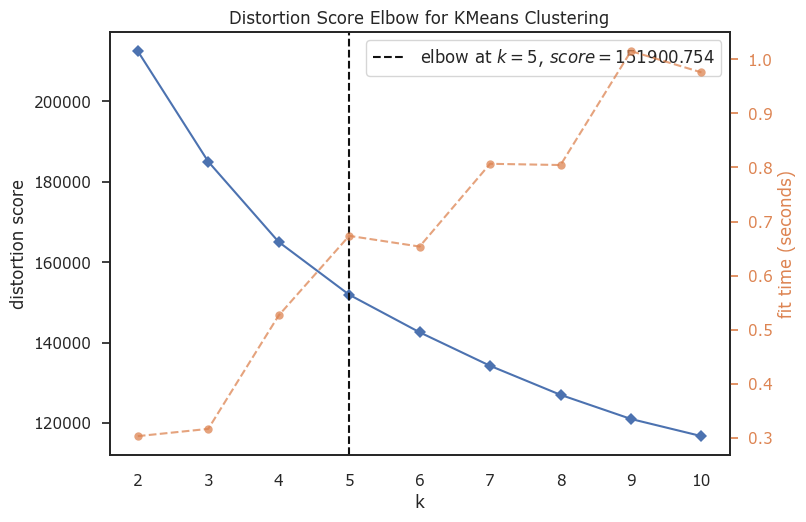

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
scaler = StandardScaler()
cluster = KElbowVisualizer(KMeans(n_init=10))
pipe = make_pipeline(scaler, cluster)

pipe.fit(df_num)
pipe[1].show()

The elbow method suggests 5 clusters.

#### Clustering the data

In [32]:
# Pipeline :
# 1. scale data
# 2. create clusters

scaler = StandardScaler()
cluster = KMeans(n_clusters=5)
pipe = make_pipeline(scaler, cluster)
pipe.fit(df_num)

values = pipe[:1].transform(df_num)

df["clusters"] = pipe["kmeans"].labels_

In [33]:
cluster_sizes = df.groupby('clusters').size().to_frame()
cluster_sizes.columns = ["size"]
cluster_sizes.reset_index(inplace = True)
cluster_sizes['clusters'] =cluster_sizes['clusters'].map({0:'private and cozy', 1:'spacious', 2:'sunny', 3:'beautiful', 4:'large', })

cluster_sizes

,clusters,size
0,private and cozy,6890
1,spacious,7407
2,sunny,4258
3,beautiful,3252
4,large,4477


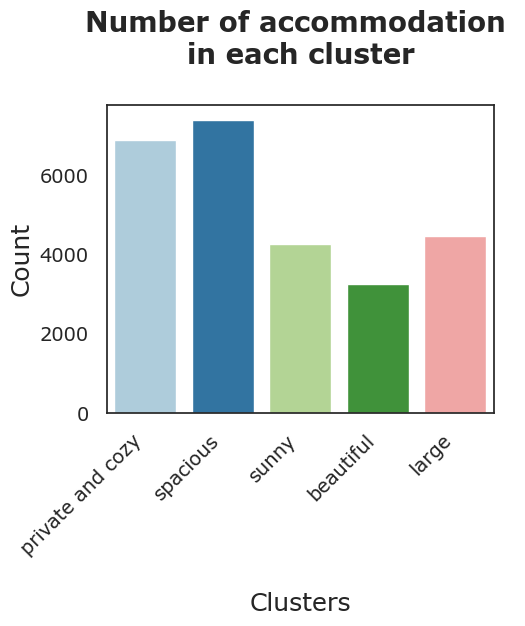

In [34]:
plt.figure(figsize=(5,4))

sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})
colors = sns.color_palette("Paired", 5)


sns.barplot(palette=colors, data=cluster_sizes, x='clusters', y='size')
plt.xlabel('\nClusters', fontsize=18);
plt.ylabel('Count', fontsize=18);
plt.title('Number of accommodation \nin each cluster\n', fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

#### Plotting column by cluster 

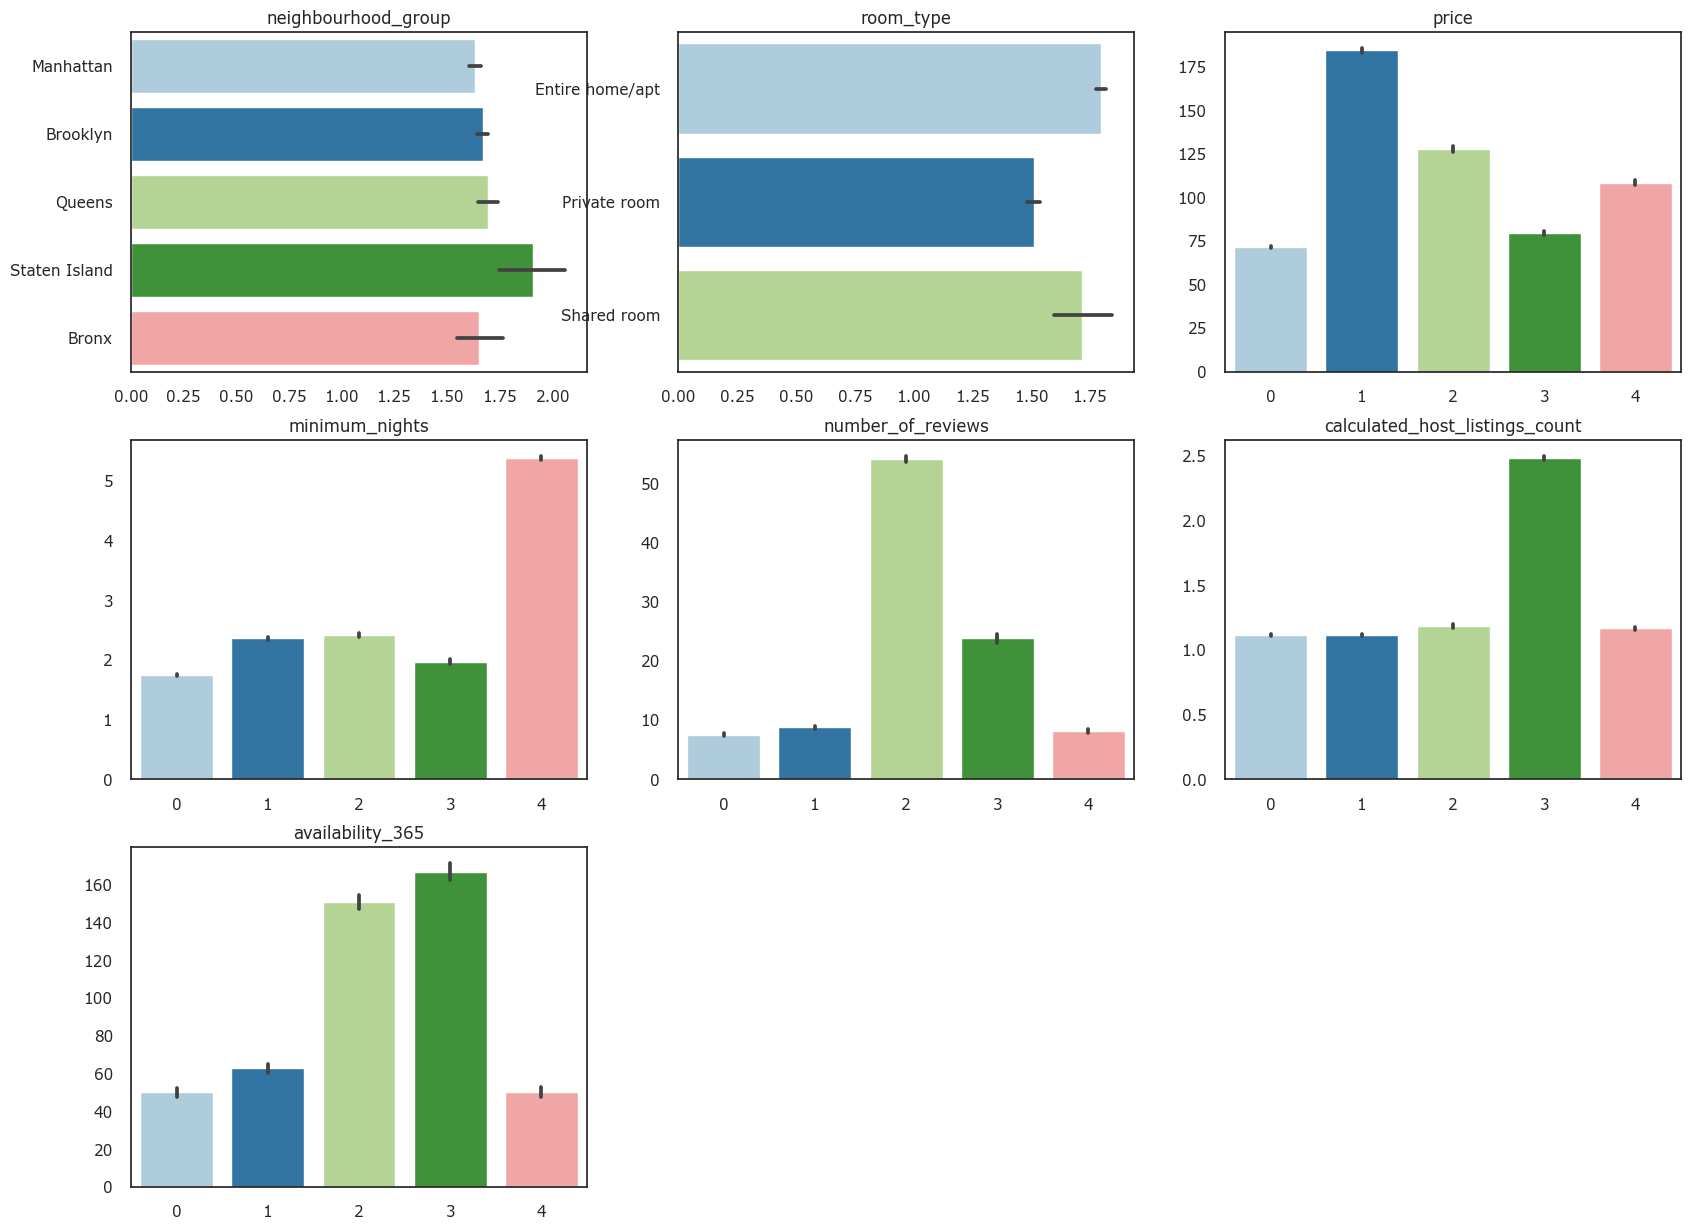

In [35]:
var_list = ['neighbourhood_group','room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365' ]

sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})
colors = sns.color_palette("Paired", 5)

cols=3

rows = math.ceil(len(var_list)/cols)

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize = (20, 5*rows))

for i, ax in zip(var_list, axs.flat):
    g = sns.barplot(data = df, x="clusters", y=i, ax = ax, palette=colors)
    ax.set(xlabel="", ylabel ="", title=i)
    
    
# Flat the plot: go backwards and drop the "ax" that is not plotting anything
for i in axs.flat[::-1][:rows*cols-len(var_list)]:
    i.set_axis_off()
    
plt.show()

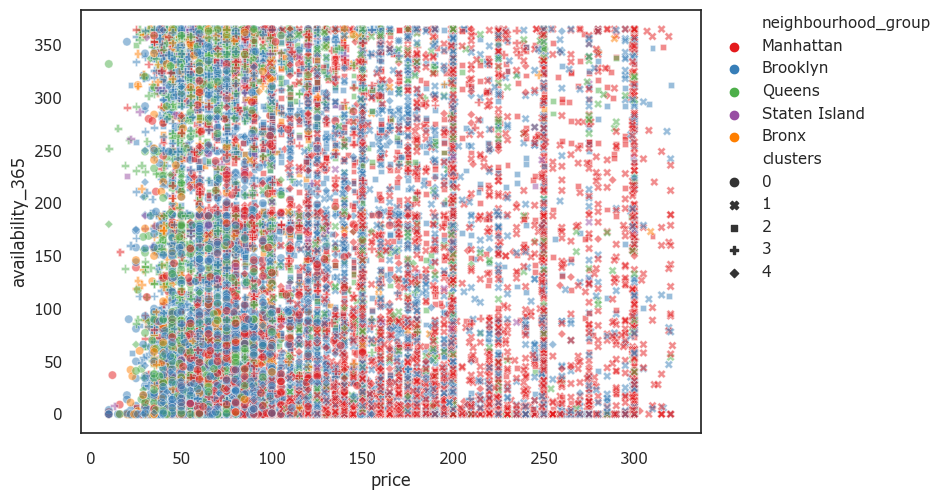

In [36]:
# Scatterplot by 5 clasters
sns.scatterplot(data = df,
            y = 'availability_365',
            x = 'price',
            hue = 'neighbourhood_group',
            style = 'clusters',
            palette='Set1',
            alpha=0.5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

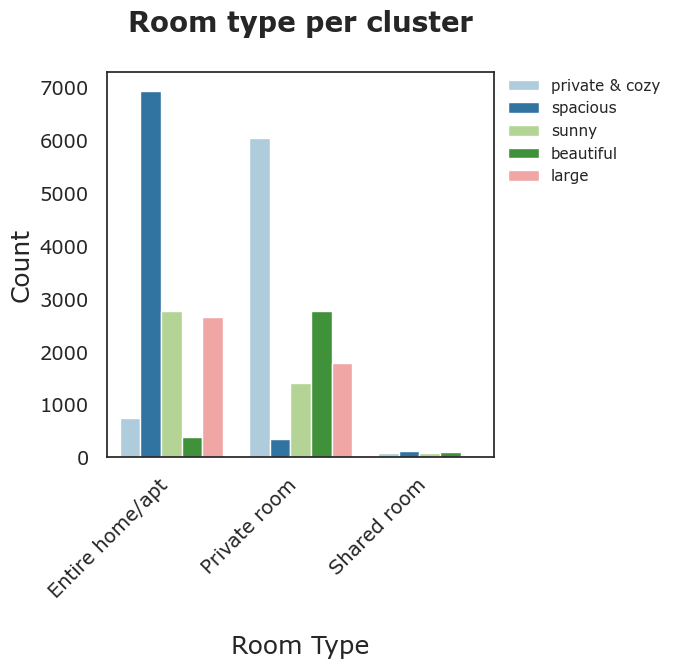

In [37]:
plt.figure(figsize=(5,5))
# Bar plot availability by neighborhood 
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})
colors = sns.color_palette("Paired", 5)

sns.countplot(data = df,
            x = 'room_type',
            hue = 'clusters', palette=colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,
          labels=['private & cozy', 'spacious', 'sunny', 'beautiful', 'large'])

plt.xlabel('\nRoom Type', fontsize=18);
plt.ylabel('Count', fontsize=18);
plt.title('Room type per cluster\n', fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

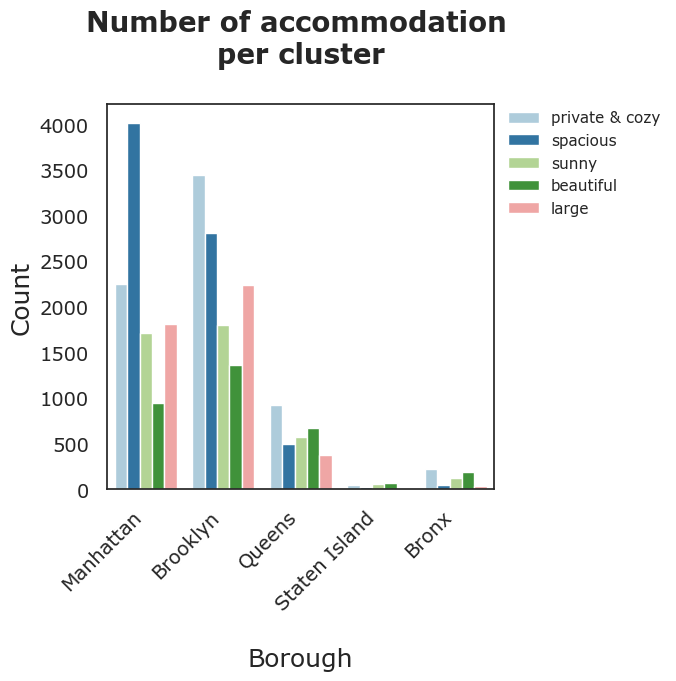

In [38]:
plt.figure(figsize=(5,5))
# Bar plot availability by neighborhood 
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})
colors = sns.color_palette("Paired", 5)

sns.countplot(data = df,
            x = 'neighbourhood_group',
            hue = 'clusters', palette = colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,
          labels=['private & cozy', 'spacious', 'sunny', 'beautiful', 'large'])
plt.xlabel('\nBorough', fontsize=18);
plt.ylabel('Count', fontsize=18);
plt.title('Number of accommodation \nper cluster\n', fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

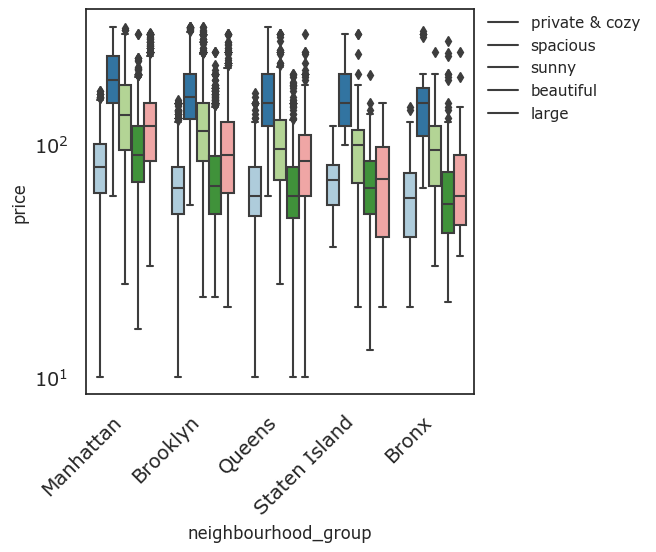

In [39]:
plt.figure(figsize=(5,5))
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})
colors = sns.color_palette("Paired", 5)


# Box plot availability by neighborhood 
fig = sns.boxplot(data = df,
            y = 'price',
            x = 'neighbourhood_group',
            hue = 'clusters',
            palette = colors)
fig.set_yscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,
          labels=['private & cozy', 'spacious', 'sunny', 'beautiful', 'large'])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

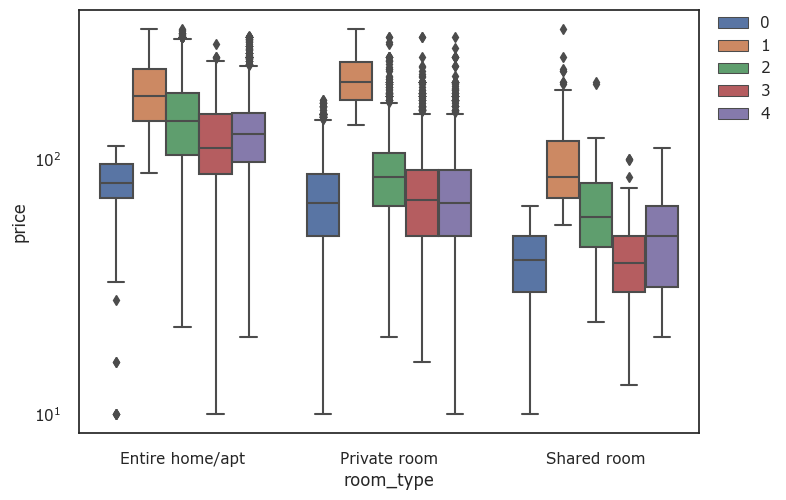

In [40]:
# Box plot by group
# Box plot availability by neighborhood 
fig = sns.boxplot(data = df,
            y = 'price',
            x = 'room_type',
            hue = 'clusters')
fig.set_yscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()


Location could provide a good signal of price.



# Natural Language Processing
Look at the names that homeowners gave their Airbnbs, and see how people advertise their homes using text features.

In [41]:
# Create corpus
word_lst = []

for i in df['name']:
    string = str(i).split()
    for term in string:
        word_lst.append(term.lower())

In [42]:
# Remove stop words 
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
filtered_words = [word for word in word_lst if word not in stopwords.words('english')]

In [44]:
# plotting top 25 words used by the host in naming their home
words_count = Counter(filtered_words).most_common()
words_count = words_count[:25]
# converting the data into a dataframe so we can plot it using Seaborn
words_df = pd.DataFrame(words_count)
words_df.head()

,0,1
0,room,5072
1,bedroom,4082
2,private,4075
3,apartment,3706
4,cozy,2909


In [45]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [46]:
sid = SentimentIntensityAnalyzer()

In [47]:
data = []
for i,row in df.iterrows():
    dic = {}
    ss = sid.polarity_scores(str(row['name']))
    
    dic['name'] = row['name']
    dic['sentiment_neu'] = ss['neu']
    dic['sentiment_pos'] = ss['pos']
    dic['sentiment_compound'] = ss['compound']
    dic['price'] = row['price']
    data.append(dic)

In [48]:
# building our dataframe from the data
sentiment_df = pd.DataFrame(data)
sentiment_df.head()

,name,sentiment_neu,sentiment_pos,sentiment_compound,price
0,Skylit Midtown Castle,1.000,0.000,0.0000,225
1,Large Cozy 1 BR Apartment In Midtown East,1.000,0.000,0.0000,200
2,Beautiful 1br on Upper West Side,0.562,0.438,0.5994,135
3,Hip Historic Brownstone Apartment with Backyard,1.000,0.000,0.0000,99
4,Sweet and Spacious Brooklyn Loft,0.571,0.429,0.4588,299


In [49]:
df_cluster= df[['name', 'clusters']]
df_cluster.reset_index(inplace = True)

In [50]:
df_cluster = pd.concat([sentiment_df, df_cluster], axis=1)

In [51]:
df_cluster['col'] = np.where(df_cluster['sentiment_compound'] > 0, 'Good', 'Bad')

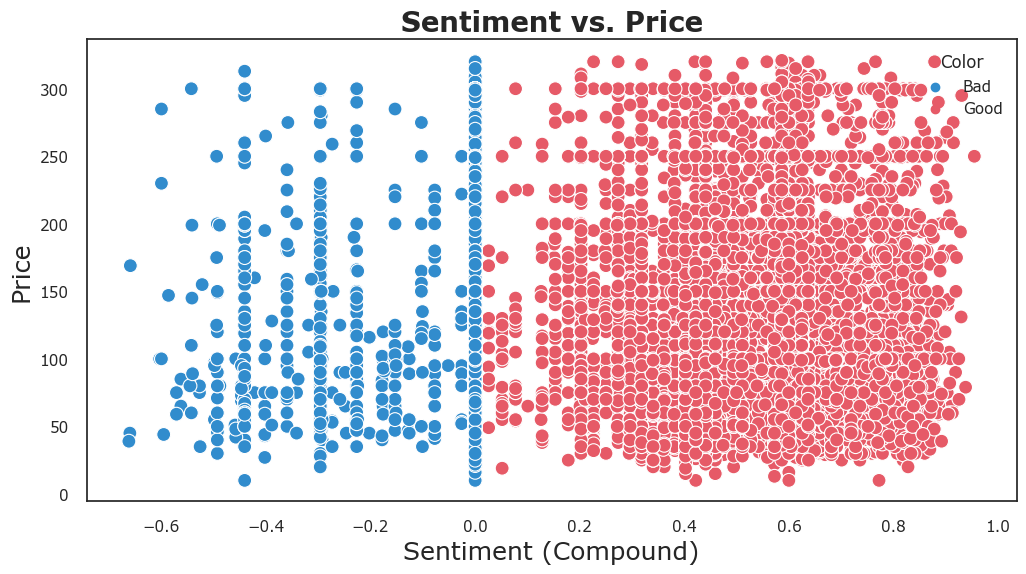

In [52]:
# Set a custom color palette
custom_palette = ['#318ccd','#e65a67']

# Create the scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='sentiment_compound', y='price', data=df_cluster, hue='col', palette=custom_palette, s=100)
plt.xlabel('Sentiment (Compound)', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.title('Sentiment vs. Price', fontsize=20, fontweight='bold')
plt.legend(title='Color', loc='upper right')

plt.show()

In [53]:
df_cluster[df_cluster['sentiment_compound']==0].count() #14246
df_cluster[df_cluster['sentiment_compound']<0].count()  #549
df_cluster[df_cluster['sentiment_compound']>0].count()  #11470

name                  11470
sentiment_neu         11470
sentiment_pos         11470
sentiment_compound    11470
price                 11470
index                 11470
name                  11470
clusters              11470
col                   11470
dtype: int64

# Linear regression

In [54]:
df1 = df.copy()

In [55]:
# drop columns 
df1.drop(columns=['id', 'name', 'host_id', 'host_name','neighbourhood', 'last_review', 'neighbourhood_group', 'room_type'], inplace = True)

df1.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_int,room_type_int,price_transf,minimum_nights_transf,number_of_reviews_transf,clusters
1,40.75362,-73.98377,225,1,45,0.38,2,355,2,2,5.416100,0.000000,3.806662,2
4,40.74767,-73.97500,200,3,74,0.59,1,129,2,2,5.298317,1.098612,4.304065,2
9,40.80316,-73.96545,135,5,53,0.43,1,6,2,2,4.905275,1.609438,3.970292,2
17,40.67592,-73.94694,99,3,53,4.44,1,21,1,2,4.595120,1.098612,3.970292,2
18,40.71842,-73.95718,299,3,9,0.07,1,0,1,2,5.700444,1.098612,2.197225,1


In [56]:
X = df1.select_dtypes('number'). drop("price", axis = 1)
y = df1['price']

In [57]:
# Scale the data but not the dummie data
scaling = [col for col in X.columns if X[col].nunique() > 2 ]

In [58]:
scaled = X[scaling].apply(zscore)

In [59]:
scaled.agg(['mean', 'std']).astype(int)

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_int,room_type_int,price_transf,minimum_nights_transf,number_of_reviews_transf,clusters
mean,0,0,0,0,0,0,0,0,0,0,0,0,0
std,1,1,1,1,1,1,1,1,1,1,1,1,1


In [60]:
scaled

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_int,room_type_int,price_transf,minimum_nights_transf,number_of_reviews_transf,clusters
1,0.457845,-0.726732,-1.029527,1.301260,-0.543772,1.166783,2.304946,0.277697,0.858474,1.405306,-1.354722,1.283126,0.240493
4,0.352138,-0.535173,0.196576,2.676043,-0.401706,-0.514009,0.379693,0.277697,0.858474,1.192952,0.484403,1.653069,0.240493
9,1.337970,-0.326577,1.422678,1.680511,-0.509947,-0.514009,-0.668121,0.277697,0.858474,0.484329,1.339548,1.404825,0.240493
17,-0.922569,0.077728,0.196576,1.680511,2.202825,-0.514009,-0.540339,-0.878671,0.858474,-0.074856,0.484403,1.404825,0.240493
18,-0.167516,-0.145939,0.196576,-0.405367,-0.753487,-0.514009,-0.719234,-0.878671,0.858474,1.917953,0.484403,0.086107,-0.463339
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38814,-0.170536,-0.866961,0.809627,-0.784617,-0.124341,-0.514009,-0.608490,0.277697,0.858474,0.674285,0.965996,-1.548079,1.648157
38816,0.944099,-0.069054,-1.029527,-0.784617,-0.124341,-0.514009,0.533032,0.277697,-1.031003,0.402364,-1.354722,-1.548079,-1.167172
38818,-3.305516,-4.199258,-1.029527,-0.784617,-0.124341,-0.514009,0.021903,2.590433,-1.031003,1.483706,-1.354722,-1.548079,-0.463339
38819,1.421648,0.578796,-1.029527,-0.737211,0.552161,-0.514009,-0.378482,3.746800,0.858474,-0.056736,-1.354722,-1.032551,-1.167172


In [61]:
estimator = LinearRegression()

rfe = RFE(estimator, n_features_to_select=3)
rfe = rfe.fit(scaled, y)
print("Selected features", scaled.columns[rfe.support_])

Selected features Index(['minimum_nights', 'price_transf', 'clusters'], dtype='object')


In [62]:
# OLS = ordinary least squares
scaled = scaled[scaled.columns[rfe.support_]]
scaled = sm.add_constant(scaled)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size=0.2)

In [64]:
model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                 7.538e+04
Date:                Mon, 19 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:05:50   Log-Likelihood:                -91735.
No. Observations:               21027   AIC:                         1.835e+05
Df Residuals:                   21023   BIC:                         1.835e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            119.6382      0.131    913.550      0.000     119.382     119.895
minimum_nights     1.6186      0.166      9.727      0.000       1.292       1.945
price_transf      62.2056      0.132    471.396      0.000      61.947      62.464
clusters          -3.0611      0.166    -18.494      0.000      -3.386      -2.737
==============================================================================
Omnibus:                     7109.603   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23943.965
Skew:                           1.725   Prob(JB):                         0.00
Kurtosis:                       6.928   Cond. No.                         2.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
clf = LinearRegression()
clf.fit(X_train,y_train)

LinearRegression()

In [66]:
predicts = clf.predict(X_test)

In [67]:
d = {'predicts':predicts,'y_test':y_test}
df2 = pd.DataFrame(d)

df2.head()

,predicts,y_test
13622,70.694692,65
8769,106.199068,90
36832,132.821882,120
20145,61.717770,60
35098,157.022538,145


In [68]:
clf.score(X_test,y_test)

0.9166934594383396

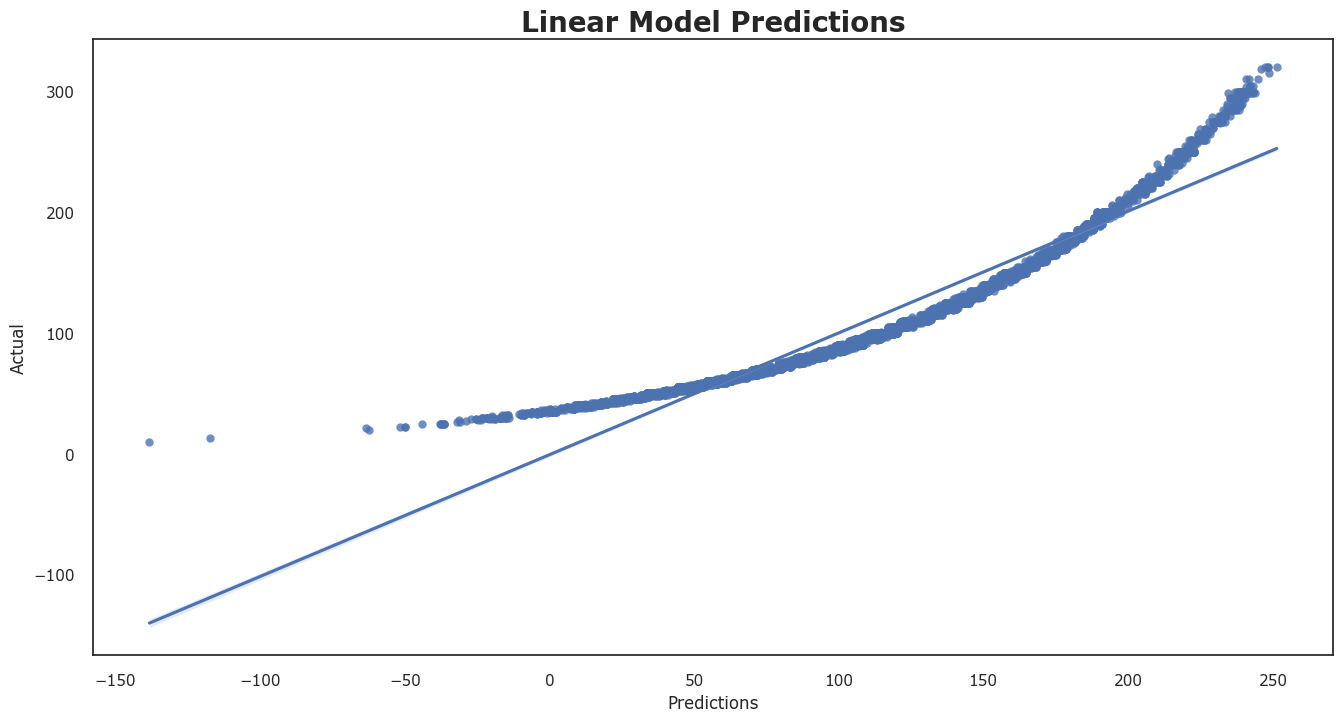

In [69]:
plt.figure(figsize=(16,8))
sns.regplot(data = df2, y='y_test',x='predicts')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Linear Model Predictions",  fontsize=20, fontweight='bold')
plt.grid(False)
plt.show()

## Word frequency per cluster

In [70]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Cluster 0

In [71]:
df0 = df[df['clusters']== 0 ]

# Create corpus
word_lst = []

for i in df0['name']:
    string = str(i).split()
    for term in string:
        word_lst.append(term.lower())
        
filtered_words = [word for word in word_lst if word not in stopwords.words('english')]

# plotting top 100 words used by the host in naming their home
words_count = Counter(filtered_words).most_common()
words_count = words_count[:20]
# converting the data into a dataframe so we can plot it using Seaborn
words_df = pd.DataFrame(words_count)
words_df.head()

,0,1
0,room,2494
1,private,1707
2,bedroom,1313
3,cozy,944
4,apartment,770


No handles with labels found to put in legend.


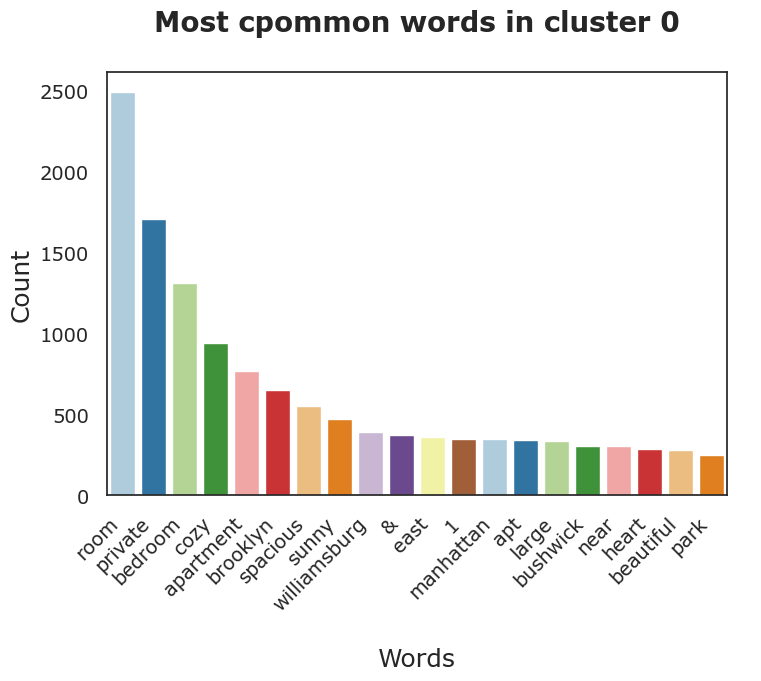

In [72]:
# plotting top 100 words used by the host in naming their home
words_count = Counter(filtered_words).most_common()
words_count = words_count[:20]
# converting the data into a dataframe so we can plot it using Seaborn
words_df = pd.DataFrame(words_count)
words_df.head()

words_df.columns=['words', 'count']
# Bar plot availability by neighborhood 
words_df.columns=['words', 'count']
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})
colors = sns.color_palette("Paired", 20)

sns.barplot(data = words_df,
            x = 'words',
            y = 'count',
            palette=colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.xlabel('\nWords', fontsize=18);
plt.ylabel('Count', fontsize=18);
plt.title('Most cpommon words in cluster 0\n', fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

## Cluster 1

In [73]:
df1 = df[df['clusters']== 1 ]

# Create corpus
word_lst = []

for i in df1['name']:
    string = str(i).split()
    for term in string:
        word_lst.append(term.lower())
        
filtered_words = [word for word in word_lst if word not in stopwords.words('english')]

# plotting top 25 words used by the host in naming their home
words_count = Counter(filtered_words).most_common()
words_count = words_count[:20]
# converting the data into a dataframe so we can plot it using Seaborn
words_df = pd.DataFrame(words_count)
words_df.columns=['words', 'count']

No handles with labels found to put in legend.


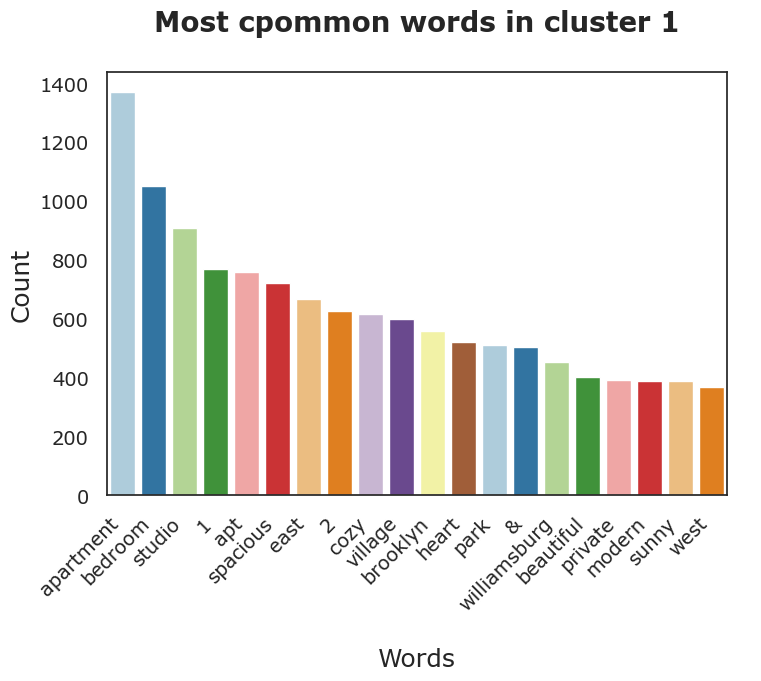

In [74]:
# Bar plot availability by neighborhood 
words_df.columns=['words', 'count']
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})
colors = sns.color_palette("Paired", 20)

sns.barplot(data = words_df,
            x = 'words',
            y = 'count',
            palette=colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.xlabel('\nWords', fontsize=18);
plt.ylabel('Count', fontsize=18);
plt.title('Most cpommon words in cluster 1\n', fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

## Cluster 2

In [75]:

df2 = df[df['clusters']== 2 ]

# Create corpus
word_lst = []

for i in df2['name']:
    string = str(i).split()
    for term in string:
        word_lst.append(term.lower())
        
filtered_words = [word for word in word_lst if word not in stopwords.words('english')]

# plotting top 25 words used by the host in naming their home
words_count = Counter(filtered_words).most_common()
words_count = words_count[:20]
# converting the data into a dataframe so we can plot it using Seaborn
words_df = pd.DataFrame(words_count)
words_df.head()

,0,1
0,private,671
1,apartment,586
2,bedroom,565
3,room,521
4,cozy,469


No handles with labels found to put in legend.


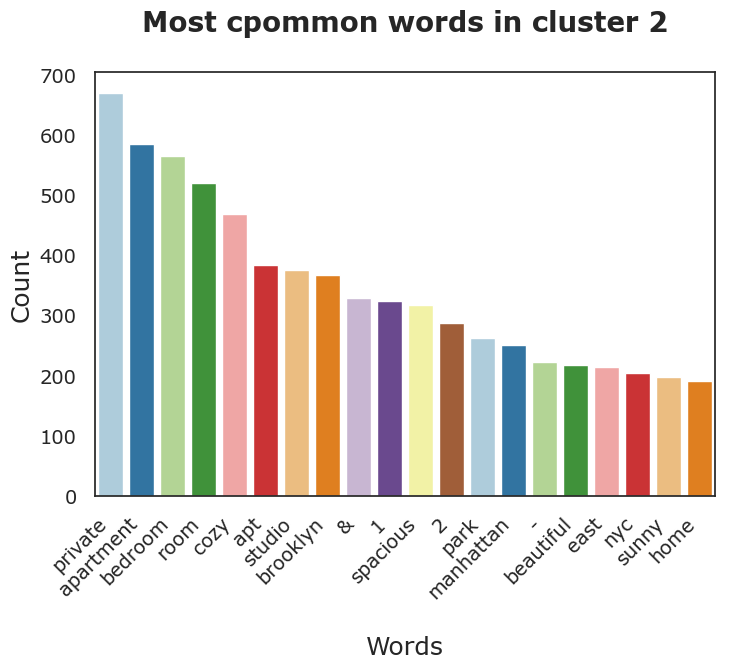

In [76]:
words_df.columns=['words', 'count']
# Bar plot availability by neighborhood 
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})
colors = sns.color_palette("Paired", 20)

sns.barplot(data = words_df,
            x = 'words',
            y = 'count',
            palette=colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.xlabel('\nWords', fontsize=18);
plt.ylabel('Count', fontsize=18);
plt.title('Most cpommon words in cluster 2\n', fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

## Cluster 3

In [77]:
## Cluster 3
df3 = df[df['clusters']== 3 ]

# Create corpus
word_lst = []

for i in df3['name']:
    string = str(i).split()
    for term in string:
        word_lst.append(term.lower())
        
filtered_words = [word for word in word_lst if word not in stopwords.words('english')]

# plotting top 25 words used by the host in naming their home
words_count = Counter(filtered_words).most_common()
words_count = words_count[:20]
# converting the data into a dataframe so we can plot it using Seaborn
words_df = pd.DataFrame(words_count)
words_df.head()

,0,1
0,room,1175
1,private,747
2,bedroom,446
3,cozy,401
4,manhattan,248


No handles with labels found to put in legend.


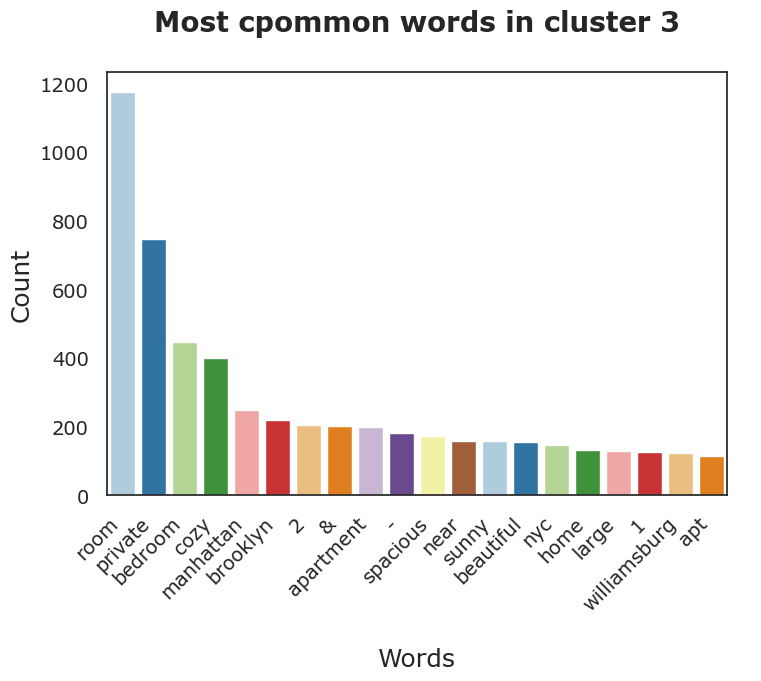

In [78]:
words_df.columns=['words', 'count']
# Bar plot availability by neighborhood 
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})
colors = sns.color_palette("Paired", 20)

sns.barplot(data = words_df,
            x = 'words',
            y = 'count',
            palette=colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.xlabel('\nWords', fontsize=18);
plt.ylabel('Count', fontsize=18);
plt.title('Most cpommon words in cluster 3\n', fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

## Cluster 4

In [79]:
df4 = df[df['clusters']== 4 ]

# Create corpus
word_lst = []

for i in df4['name']:
    string = str(i).split()
    for term in string:
        word_lst.append(term.lower())
        
filtered_words = [word for word in word_lst if word not in stopwords.words('english')]

# plotting top 25 words used by the host in naming their home
words_count = Counter(filtered_words).most_common()
words_count = words_count[:20]
# converting the data into a dataframe so we can plot it using Seaborn
words_df = pd.DataFrame(words_count)
words_df.head()

,0,1
0,apartment,782
1,room,765
2,bedroom,708
3,private,558
4,cozy,479


No handles with labels found to put in legend.


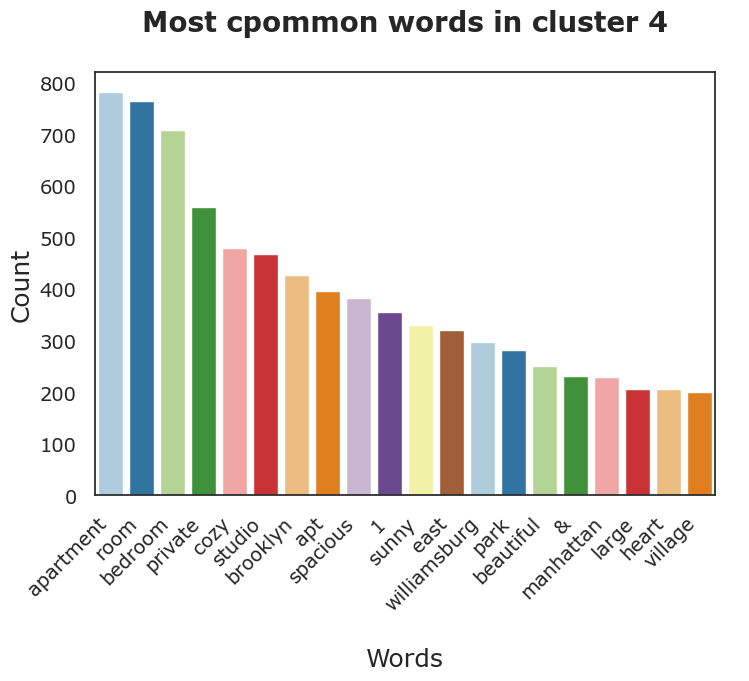

In [80]:
words_df.columns=['words', 'count']
# Bar plot availability by neighborhood 
sns.set(style = "white" )  
sns.set_style({'font.family': 'Verdana'})
colors = sns.color_palette("Paired", 20)

sns.barplot(data = words_df,
            x = 'words',
            y = 'count',
            palette=colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.xlabel('\nWords', fontsize=18);
plt.ylabel('Count', fontsize=18);
plt.title('Most cpommon words in cluster 4\n', fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()